In [1]:
import datetime as dt
import pandas_datareader.data as web
from matplotlib import style
import matplotlib.pyplot as plt
import math 
import numpy as np
import yfinance as yf
import pandas as pd
from scipy import optimize as scopti
import bs4 as bs
import pickle
import requests

In [2]:
import data
import risk_metrics as rm
import markowitz_construction as mc

## Getting All Components of S&P 500 Index 

In [3]:
def spx_components():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.rsplit(":")[-1].strip())
  
    return tickers

In [4]:
tickers_list=['^GSPC']+spx_components()

## Getting Prices from Yahoo Finance and Calculating Returns

In [5]:
prices=data.data_pandas_reader_tenor(tickers_list,'5y','1d',field='Adj Close')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
prices2=prices.dropna(axis=1)
gross_returns=mc.stock_returns(prices2)

### Assuming Risk free Rate as 13 Week Treasury Bill (^IRX)

In [7]:
risk_free_rate=data.data_pandas_reader_tenor(['^IRX'],'5y','1d',field='Adj Close')

[*********************100%***********************]  1 of 1 completed


In [8]:
returns_all=gross_returns.merge(risk_free_rate,how='left',left_index=True, right_index=True)
returns_all.fillna(method='bfill',inplace=True)

In [9]:
n_constituents=len(gross_returns.columns[1:])
constituent_rets=gross_returns[gross_returns.columns[1:]]
constituent_prices=prices2[gross_returns.columns[1:]]
rf=gross_returns[gross_returns.columns[-1]]

## Creating a Equally Weighted Portfolio 

In [10]:
weight_ew=np.repeat(1/n_constituents,n_constituents)
EW_index=constituent_prices.dot(weight_ew)
EW_rets=mc.stock_returns(EW_index)

## Creating a Mean-Variance Efficient Portfolio

In [11]:
weight_mve=mc.optimal_weights_for_max_sharpe_ratio(rf, constituent_rets, 252)
MVE_index=constituent_prices.dot(weight_mve)
MVE_rets=mc.stock_returns(MVE_index)

## Creating Global Minimum Variance Portfolio

In [12]:
weight_gmv=mc.optimal_weights_for_gmv(constituent_rets, 252)
GMV_index=constituent_prices.dot(weight_gmv)
GMV_rets=mc.stock_returns(GMV_index)

In [13]:
SPX_index=prices2['^GSPC']
SPX_rets=mc.stock_returns(SPX_index)

## Plotting Cumulative Returns of Smart Benchmarks

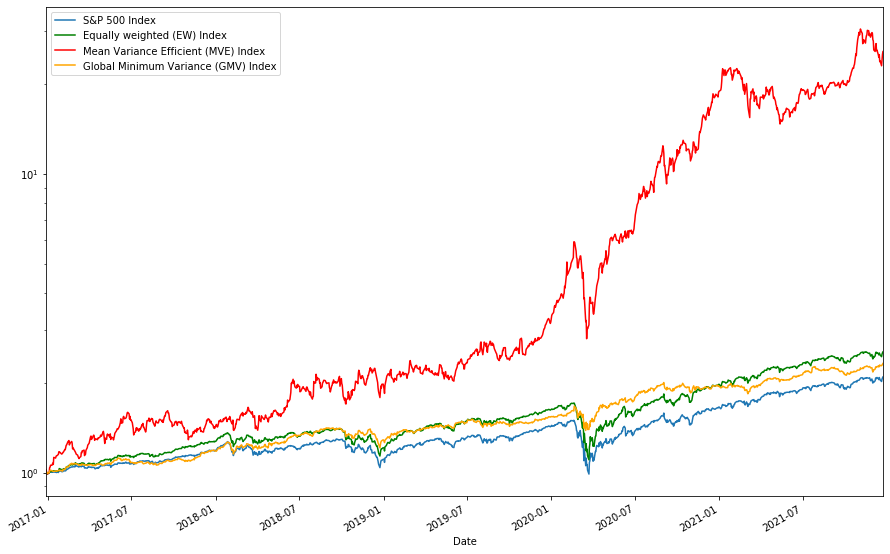

In [20]:
ax=mc.cumulative_returns(SPX_rets).plot.line(x="Date", y="Cumulative Returns",figsize=(15,10), 
                                                                label='S&P 500 Index')
ax.plot(mc.cumulative_returns(EW_rets),color='green', label='Equally weighted (EW) Index')
ax.plot(mc.cumulative_returns(MVE_rets),color='red', label='Mean Variance Efficient (MVE) Index')
ax.plot(mc.cumulative_returns(GMV_rets),color='orange', label='Global Minimum Variance (GMV) Index')
ax.set_yscale('log')
plt.legend()

## Risk-Return Summary Comparison of Smart Benchmarks

In [16]:
concat_rets=pd.concat([SPX_rets,GMV_rets, EW_rets,MVE_rets], axis=1)
concat_rets.columns=['S&P 500','GMV','EW', 'MVE']

In [22]:
rm.summary_stats(concat_rets, rf,period_freq=252)

,Annualized Return,Annualized Vol,Skewness,Excess Kurtosis,Cornish-Fisher VaR (5%),Gaussian VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
S&P 500,0.159021,0.192370,-0.737117,20.327108,0.016710,0.019265,0.030650,0.820095,-0.339250
GMV,0.183473,0.141611,-0.158885,9.387676,0.012668,0.013959,0.021169,1.286119,-0.170773
EW,0.204795,0.193948,-0.872554,20.437606,0.017091,0.019273,0.030553,1.049204,-0.354465
MVE,0.915652,0.458603,-0.031549,4.595819,0.042080,0.044500,0.063241,1.992307,-0.526440
